### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from pathlib import Path
from utils.train.train import (
    train_test)
from utils.train.importances import (
    features_importance
)
from utils.permutation.permutation import permutation

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Better rendering 
from IPython.core.display import HTML
HTML("<style>.rendered_html th {max-width: 120px;}</style>")

warnings.filterwarnings('ignore')

# settings to display all columns
pd.set_option("display.max_columns", None)

In [3]:
%%html
<style>
.dataframe td {
    white-space: nowrap;
}
</style>

---

#### Import Procesed DataFrame

In [4]:
# Import Data
data_size = 'improved'
data = pd.read_pickle('data/data_features_{}.pkl'.format(data_size))

# Start records from 55th
start_row = 55
data = data[data['d'] >= start_row].copy()
print("{:,} records for the prepared data".format(len(data)))

# Drop columns
data.drop(['Unnamed: 0'], axis = 1, inplace = True)
data.head()

58,388,350 records for the prepared data


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,delta_price_all_rel,delta_price_weekn-1,delta_price_cat_rel,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_7,sold_lag_14,sold_lag_28,iteam_sold_avg,state_sold_avg,store_sold_avg,cat_sold_avg,dept_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean,rolling_sold_mean_3,rolling_sold_mean_7,rolling_sold_mean_14,rolling_sold_mean_21,rolling_sold_mean_28,rolling_lag_7_win_7,rolling_lag_7_win_28,rolling_lag_28_win_7,rolling_lag_28_win_28,selling_trend,item_selling_trend,rolling_sold_max,rolling_sold_max_1,rolling_sold_max_2,rolling_sold_max_7,rolling_sold_max_14,rolling_sold_max_21,rolling_sold_max_28,stock_out_id,stock_out_id_last_1_days,stock_out_id_last_2_days,stock_out_id_last_7_days,store_closed,store_closed_last_1_days,store_closed_last_2_days,store_closed_last_7_days
1648072,0,0,0,0,0,0,55,0,11108,4,6,3,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,0.0,-0.322754,1.0,1.0,1.0,0.0,3.0,2.0,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,0.714355,0.666504,0.714355,0.856934,1.142578,1.500000,1.000000,1.571289,1.713867,NaN,-0.774902,-0.774902,1.0,0.0,1.0,1.0,5.0,5.0,7.0,0,0,0,0,0,0,0,0
1678562,0,0,0,0,0,0,56,1,11108,0,7,3,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,0.0,-0.322754,0.0,1.0,1.0,0.0,0.0,4.0,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,0.856934,0.666504,0.856934,0.928711,1.142578,1.392578,1.000000,1.857422,1.642578,1.392578,0.225098,0.225098,1.0,1.0,1.0,1.0,5.0,5.0,7.0,0,0,0,0,0,0,0,0
1709052,0,0,0,0,0,0,57,2,11109,2,1,3,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,0.0,-0.322754,1.0,0.0,1.0,1.0,1.0,2.0,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,1.000000,1.000000,1.000000,1.000000,1.142578,1.392578,1.000000,2.000000,1.642578,1.357422,1.224609,1.224609,2.0,2.0,2.0,2.0,5.0,5.0,7.0,0,0,0,0,0,0,0,0
1739542,0,0,0,0,0,0,58,2,11109,3,2,3,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,0.0,-0.322754,2.0,1.0,0.0,1.0,5.0,2.0,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,1.142578,1.666992,1.142578,0.785645,1.095703,1.392578,0.428467,2.000000,1.607422,1.428711,1.224609,1.224609,2.0,2.0,2.0,2.0,2.0,5.0,7.0,0,0,0,0,0,0,0,0
1770032,0,0,0,0,0,0,59,0,11109,1,3,3,2011,-1,-1,-1,-1,0,0,0,2.0,0.0,0.0,-0.322754,2.0,2.0,1.0,1.0,0.0,0.0,0.629883,1.21582,1.304688,1.623047,1.220703,1.220703,0.774902,0.629883,0.629883,1.304688,1.933594,1.357422,1.000000,1.333008,1.000000,0.785645,1.095703,1.392578,0.571289,2.000000,1.642578,1.428711,-0.774902,-0.774902,2.0,0.0,2.0,2.0,2.0,5.0,7.0,0,0,0,0,0,0,0,0


#### Import key data

In [5]:
LIST_NAME = ['d_id', 'd_item_id', 'd_dept_id', 'd_cat_id', 'd_store_id', 'd_state_id']
dict_data = {}
for list_name in LIST_NAME:
    dict_temp = pickle.load(open('data/params/{}.p'.format(list_name), "rb"))
    dict_data[list_name] = dict_temp
    del dict_temp

In [6]:
# Initial Features
INIT_FEAT = list(data.columns[0:21])

# Lags and averages
LAGAV_FEAT = list(data.columns[24:42])

# Rolling Means and Rolling Means on lag
ROLLMEAN_FEAT = list(data.columns[42:52])

# Trends and Rolling MAX
TREND_MAX_FEAT = list(data.columns[52:58])

# Stock-Out and Store Closed
# SO_CLOSED_FEAT = list(data.columns[58:67])
SO_CLOSED_FEAT = list(['stock_out_id', 'store_closed'])

# PRICE COMPARISON
PRICE_COMPARE = list(data.columns[21:24])

# Dictionnary with different steps
dict_features = {
    'STEP_1': INIT_FEAT,
    'STEP_2': INIT_FEAT+LAGAV_FEAT,
    'STEP_3': INIT_FEAT+LAGAV_FEAT+ROLLMEAN_FEAT,
    'STEP_4': INIT_FEAT+LAGAV_FEAT+ROLLMEAN_FEAT+TREND_MAX_FEAT,
    'STEP_5': INIT_FEAT+LAGAV_FEAT+ROLLMEAN_FEAT+TREND_MAX_FEAT+SO_CLOSED_FEAT,
    'STEP_6': INIT_FEAT+LAGAV_FEAT+ROLLMEAN_FEAT+TREND_MAX_FEAT+SO_CLOSED_FEAT+PRICE_COMPARE,
}
LIST_STEPS = ['STEP_1', 'STEP_2', 'STEP_3', 'STEP_4', 'STEP_5', 'STEP_6']
LIST_STEPS_NAME = ['INITIAL_DATA', 'INITIAL + LAG + AVERAGES', 
                  'INITIAL + LAG + AVERAGES + ROLLING MEAN',
                  'INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX',
                  'INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX + STOCK-OUT AND STORE CLOSED',
                  'INITIAL + LAG AND AVERAGES + ROLLING MEAN + TREND AND ROLLING MAX + STOCK-OUT AND STORE CLOSED + PRICE COMPARISON']
dict_stepname = dict(zip(LIST_STEPS, LIST_STEPS_NAME))

### 1. Baseline with all features
#### What would be the rmse if you use all features

In [7]:
folder_name = 'model_perm/initial/'
dict_error = {}
model_name = 'initial'

# Get the store ids
features = dict_features['STEP_6']
stores = data.store_id.unique()
d_store_id = dict_data['d_store_id']

# Train your model
df_validpred = train_test(data, features, stores, d_store_id, folder_name, model_name)

# Compute Error
valid_rmse = 100 * np.sqrt(np.mean((df_validpred.validation.values - df_validpred.prediction.values) ** 2))/np.mean(df_validpred.validation.values)
# Add Error in a Dictionnary
dict_error['all_features'] = valid_rmse
print("{}: RMSE = {}".format('all_features', valid_rmse))

all_features: RMSE = 4.598720935658507


filtered: RMSE = 4.598720935658507


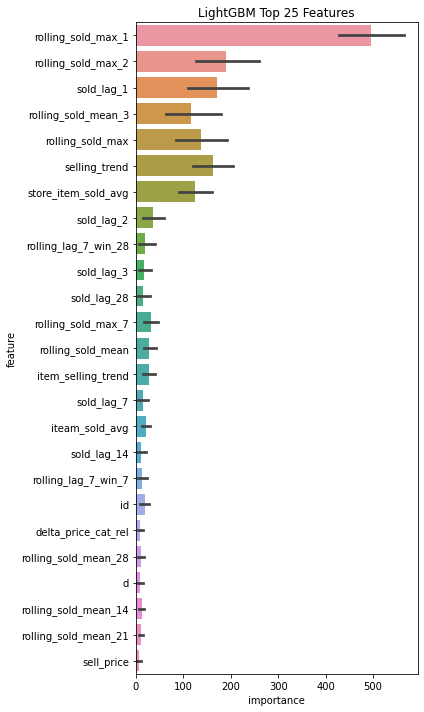

In [8]:
n_features = 25
features_importance(folder_name, 'initial', features, d_store_id, valid_rmse, stores, n_features)

### 2. Permutation Importance
#### For each feature test the impact on the rmse if you remove the feature (by permutation) with the same training model

In [9]:
# Baseline with initial features
baseline_rmse = valid_rmse
folder_model = 'model_perm/initial/'
print("Baseline with all features: RMSE = {}".format(baseline_rmse))

# Parameters
all_features = dict_features['STEP_6']
stores = data.store_id.unique()
d_store_id = dict_data['d_store_id']

# Dictionnary of error
dict_error = {}
dict_error['baseline'] = baseline_rmse

Baseline with all features: RMSE = 4.598720935658507


In [10]:
# Perform permutation
df_permres, df_validall, dict_error = permutation(data, all_features, stores, d_store_id, baseline_rmse, dict_error, folder_model)
df_permres.to_csv(folder_model + 'permutation_error' + '.csv')

Remove id: delta_rmse = 0.15194618834070894
Remove item_id: delta_rmse = 0.0021569997524526485
Remove dept_id: delta_rmse = 0.00013916964837168422
Remove cat_id: delta_rmse = 0.0
Remove store_id: delta_rmse = 0.0
Remove state_id: delta_rmse = 0.0
Remove d: delta_rmse = 0.0
Remove sold: delta_rmse = 0.0
Remove wm_yr_wk: delta_rmse = 0.0
Remove weekday: delta_rmse = 0.008830926145920515
Remove wday: delta_rmse = 0.16429796164228083
Remove month: delta_rmse = -1.5910336870206265e-07
Remove year: delta_rmse = 0.0
Remove event_name_1: delta_rmse = 0.0
Remove event_type_1: delta_rmse = 0.0
Remove event_name_2: delta_rmse = 0.0
Remove event_type_2: delta_rmse = 0.0
Remove snap_CA: delta_rmse = 0.003907777610015373
Remove snap_TX: delta_rmse = 0.0016399220384464286
Remove snap_WI: delta_rmse = 0.02859002046977288
Remove sell_price: delta_rmse = 0.13939062606693398
Remove sold_lag_1: delta_rmse = 4.258758610971684
Remove sold_lag_2: delta_rmse = 0.7560266791814021
Remove sold_lag_3: delta_rmse 

#### Features that reduce the accuracy of the model

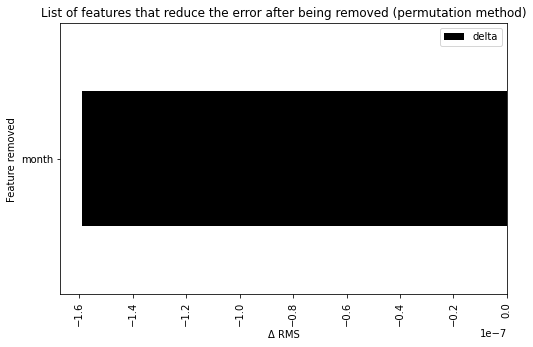

In [11]:
# Plot
fig = plt.figure(figsize=(8, 5))
ax = fig.gca()
df_permres[df_permres['delta']<0].sort_values(['delta'], ascending = True).plot.barh(figsize=(8, 5), x='remove', y='delta', ax=ax, color = 'black')
plt.ylabel('Feature removed')
plt.xlabel('Δ RMS')
plt.xticks(rotation=90)
plt.title('List of features that reduce the error after being removed (permutation method)')
fig.savefig(folder_model + 'features_remove.png')
plt.show()

#### Features that positively (in a large extente) impact the accuracy of the model

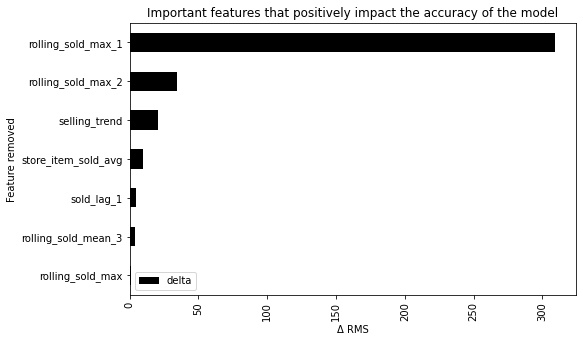

In [16]:
# Plot
fig = plt.figure(figsize=(8, 5))
ax = fig.gca()
df_permres[df_permres['delta']>1].sort_values(['delta'], ascending = True).plot.barh(figsize=(8, 5), x='remove', y='delta', ax=ax, color = 'black')
plt.ylabel('Feature removed')
plt.xlabel('Δ RMS')
plt.xticks(rotation=90)
plt.title('Important features that positively impact the accuracy of the model')
fig.savefig(folder_model + 'features_important.png')
plt.show()

In [12]:
# Features to remove 
list_remove = list(df_permres[df_permres['delta']<0]['remove'].unique())
print("Features to be removed from the training set to improve the accuracy {}".format(list_remove))

Features to be removed from the training set to improve the accuracy ['month']


### 3. Retrain the algorithm with a cleaned version of features
#### New list of features


In [13]:
# Model name
model_name = 'permutation'
# Update the features
new_features = [feat for feat in all_features if (feat not in list_remove) or (feat in ['sold'])]
# Models with filtered scope
folder_name = 'model_perm/perm/'

In [14]:
# DataFrame with filter scope
data_scope = data.copy()

# Train with the filtered scope
df_validpred = train_test(data, new_features, stores, d_store_id, folder_name, model_name)

# Save Prediction for all stores
df_validpred.to_csv(folder_name + 'error_prediction_filtered.csv')

# Compute Error
valid_rmse = 100 * np.sqrt(np.mean((df_validpred.validation.values - df_validpred.prediction.values) ** 2))/np.mean(df_validpred.validation.values)
# Add Error in a Dictionnary
dict_error['all_features'] = valid_rmse
print("{}: RMSE = {}".format('filtered', valid_rmse))

filtered: RMSE = 5.411951857220929


#### Show features importances

filtered: RMSE = 5.411951857220929


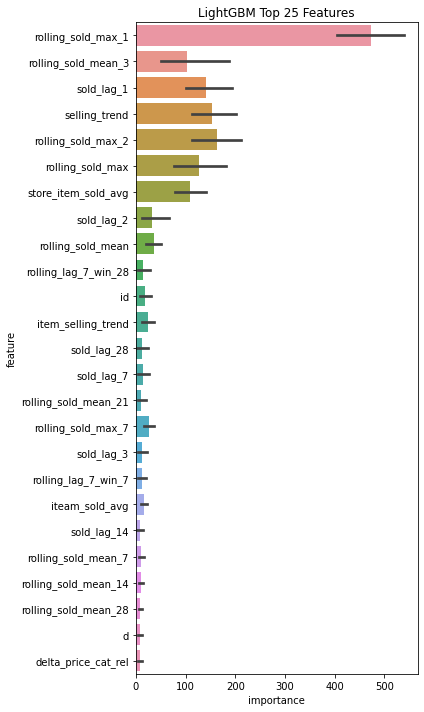

In [15]:
folder_model = 'model_perm/perm/'
n_features = 25
features_importance(folder_model, 'permutation', new_features, d_store_id, valid_rmse, stores, n_features)